In [ ]:
from google.colab import files
files.upload()

! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

#**Download the Dataset**

In [ ]:
# ! pip install --upgrade kaggle
# ! kaggle competitions download -c lyft-motion-prediction-autonomous-vehicles
# To solve "429 too many requests" error: https://www.kaggle.com/general/51898
# !wget -x --load-cookies cookies.txt "https://www.kaggle.com/c/19990/download-all" -O data.zip
#!unzip semantic_map.zip
!unzip sample.zarr.zip
!mkdir scenes
#!mkdir semantic_map
!mv sample.zarr scenes/sample.zarr

Archive:  sample.zarr.zip
   creating: sample.zarr/
  inflating: sample.zarr/LICENSE     
  inflating: sample.zarr/.zattrs     
 extracting: sample.zarr/.zgroup     
  inflating: sample.zarr/feedback.txt  
   creating: sample.zarr/agents/
  inflating: sample.zarr/agents/11   
  inflating: sample.zarr/agents/30   
  inflating: sample.zarr/agents/36   
  inflating: sample.zarr/agents/9    
  inflating: sample.zarr/agents/18   
  inflating: sample.zarr/agents/.zarray  
  inflating: sample.zarr/agents/1    
  inflating: sample.zarr/agents/8    
  inflating: sample.zarr/agents/15   
  inflating: sample.zarr/agents/13   
  inflating: sample.zarr/agents/10   
  inflating: sample.zarr/agents/14   
  inflating: sample.zarr/agents/2    
  inflating: sample.zarr/agents/24   
  inflating: sample.zarr/agents/12   
  inflating: sample.zarr/agents/25   
  inflating: sample.zarr/agents/17   
  inflating: sample.zarr/agents/19   
  inflating: sample.zarr/agents/27   
  inflating: sample.zarr/agents/5  

#**Import Libraries: zarr, l5kit and more** 

In [ ]:
!pip install zarr
import zarr
import numpy as np

z = zarr.open("s.zarr", mode="w", shape=(500,), dtype=np.float32, chunks=(100,))

# We can write to it by assigning to it. This gets persisted on disk.
z[0:150] = np.arange(150)
print(z.info)
print(z[:10])
# [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]

print(z[::20]) # Read every 20th value
# [  0.  20.  40.  60.  80. 100. 120. 140.   0.   0.   0.   0.   0.   0.
#    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]

Type               : zarr.core.Array
Data type          : float32
Shape              : (500,)
Chunk shape        : (100,)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 2000 (2.0K)
No. bytes stored   : 577
Storage ratio      : 3.5
Chunks initialized : 2/5

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[  0.  20.  40.  60.  80. 100. 120. 140.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


In [ ]:
!pip install l5kit
!pip install -U PyYAML
!pip install efficientnet_pytorch
!pip install zarr

from typing import Dict
from efficientnet_pytorch import EfficientNet

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

Requirement already up-to-date: PyYAML in /usr/local/lib/python3.6/dist-packages (5.3.1)


# **Loading Ego Dataset and Agent Dataset**

image (65, 224, 224)
target_positions (50, 2)
target_yaws (50, 1)
target_availabilities (50,)
history_positions (31, 2)
history_yaws (31, 1)
history_availabilities (31,)
world_to_image (3, 3)
raster_from_world (3, 3)
raster_from_agent (3, 3)
agent_from_world (3, 3)
world_from_agent (3, 3)
track_id ()
timestamp ()
centroid (2,)
yaw extent (3,)

In [ ]:
# EGO Dataset
path = "scenes/sample.zarr"
zarr_dt = ChunkedDataset(path)
zarr_dt.open('r')

# additional information is required for rasterisation
cfg = load_config_data("agent_motion_config.yaml")
rast = build_rasterizer(cfg, LocalDataManager("./"))

ego_dataset = EgoDataset(cfg, zarr_dt, rast)
for data in ego_dataset:  # this iterates over frames under the hood
    # print(data["target_positions"])
    # print(data["history_positions"])
    break
for k in data.keys():
  print(k, end=' ')
  if type(data[k]) != float:
    print(data[k].shape)

image (65, 224, 224)
target_positions (50, 2)
target_yaws (50, 1)
target_availabilities (50,)
history_positions (31, 2)
history_yaws (31, 1)
history_availabilities (31,)
world_to_image (3, 3)
raster_from_world (3, 3)
raster_from_agent (3, 3)
agent_from_world (3, 3)
world_from_agent (3, 3)
track_id ()
timestamp ()
centroid (2,)
yaw extent (3,)


/usr/local/lib/python3.6/dist-packages/l5kit/dataset/ego.py:152: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index)


In [ ]:
print(zarr_dt.scenes.dtype)
print(zarr_dt.frames.dtype)
print(zarr_dt.agents.dtype)
print(zarr_dt.tl_faces.dtype)

[('frame_index_interval', '<i8', (2,)), ('host', '<U16'), ('start_time', '<i8'), ('end_time', '<i8')]
[('timestamp', '<i8'), ('agent_index_interval', '<i8', (2,)), ('traffic_light_faces_index_interval', '<i8', (2,)), ('ego_translation', '<f8', (3,)), ('ego_rotation', '<f8', (3, 3))]
[('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))]
[('face_id', '<U16'), ('traffic_light_id', '<U16'), ('traffic_light_face_status', '<f4', (3,))]


image (65, 224, 224)
target_positions (50, 2)
target_yaws (50, 1)
target_availabilities (50,)
history_positions (31, 2)
history_yaws (31, 1)
history_availabilities (31,)
world_to_image (3, 3)
raster_from_world (3, 3)
raster_from_agent (3, 3)
agent_from_world (3, 3)
world_from_agent (3, 3)
track_id ()
timestamp ()
centroid (2,)
yaw extent (3,)

In [ ]:
# Agent Dataset 

# create a mask where an agent every 100th is set to True
agents_mask = np.zeros(len(zarr_dt.agents), dtype=np.bool)
agents_mask[np.arange(0, len(agents_mask), 100)] = True

agent_dataset = AgentDataset(cfg, zarr_dt, rast, agents_mask=agents_mask)
for data in agent_dataset:  # this iterates over valid agents under the hood
    # print(data["target_positions"])
    # print(data["history_positions"])
    break
for k in data.keys():
  print(k, end=' ')
  if type(data[k]) != float:
    print(data[k].shape)

image (65, 224, 224)
target_positions (50, 2)
target_yaws (50, 1)
target_availabilities (50,)
history_positions (31, 2)
history_yaws (31, 1)
history_availabilities (31,)
world_to_image (3, 3)
raster_from_world (3, 3)
raster_from_agent (3, 3)
agent_from_world (3, 3)
world_from_agent (3, 3)
track_id ()
timestamp ()
centroid (2,)
yaw extent (3,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: you're running with a custom agents_mask
  import sys
/usr/local/lib/python3.6/dist-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)


In [ ]:
cfg['model_params'], cfg['raster_params'], cfg['train_params'], cfg['train_data_loader'], cfg['val_data_loader']

({'future_delta_time': 0.1,
  'future_num_frames': 50,
  'future_step_size': 1,
  'history_delta_time': 0.1,
  'history_num_frames': 30,
  'history_step_size': 1,
  'model_architecture': 'resnet50'},
 {'dataset_meta_key': 'meta.json',
  'ego_center': [0.25, 0.5],
  'filter_agents_threshold': 0.5,
  'map_type': 'py_semantic',
  'pixel_size': [0.5, 0.5],
  'raster_size': [224, 224],
  'satellite_map_key': 'aerial_map.png',
  'semantic_map_key': 'semantic_map.pb'},
 {'checkpoint_every_n_steps': 10000,
  'eval_every_n_steps': 10000,
  'max_num_steps': 5},
 {'batch_size': 12,
  'key': 'scenes/sample.zarr',
  'num_workers': 16,
  'shuffle': True},
 {'batch_size': 12,
  'key': 'scenes/sample.zarr',
  'num_workers': 16,
  'shuffle': False})

# **Define The Baseline Model**

In [ ]:
# baseline

def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50(pretrained=True)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

# **Multi-mode Model**

In [ ]:
class MultiMode(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        backbone = resnet50(pretrained=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        backbone_out_features = 2048

        # X, Y coords for the future positions (output shape: Bx50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_features=backbone_out_features, out_features=4096),
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.head(x)
        x = self.logit(x)

        # pred (bs)x(modes)x(time)x(2D coords)
        # confidences (bs)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

In [ ]:
class MultiModeWtihState(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        backbone = resnet50(pretrained=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        backbone_out_features = 2048
        state_features = (cfg["model_params"]["history_num_frames"] + 1) * 4

        # X, Y coords for the future positions (output shape: Bx50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_features=backbone_out_features + state_features, out_features=4096),
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x, history_positions, history_yaws, history_avails):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        state = torch.cat([history_positions, history_yaws, history_avails], dim=-1)
        state = torch.flatten(state, 1)
        features = torch.cat([x, state], dim=1)

        x = self.head(features)
        x = self.logit(x)

        # pred (bs)x(modes)x(time)x(2D coords)
        # confidences (bs)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

# **EfficientNet**

In [ ]:
class MultiModeEfficientNet(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone._conv_stem = nn.Conv2d(
            num_in_channels,
            self.backbone._conv_stem.out_channels,
            kernel_size=self.backbone._conv_stem.kernel_size,
            stride=self.backbone._conv_stem.stride,
            padding=self.backbone._conv_stem.padding,
            bias=False,
        )

        backbone_out_features = 1000
        state_features = (cfg["model_params"]["history_num_frames"] + 1) * 4

        # X, Y coords for the future positions (output shape: Bx50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_features=backbone_out_features + state_features, out_features=4096),
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x, history_positions, history_yaws, history_avails):

        x = self.backbone.extract_features(x)
        # Pooling and final linear layer
        x = self.backbone._avg_pooling(x)
        x = x.flatten(start_dim=1)
        x = self.backbone._dropout(x)
        x = self.backbone._fc(x)

        state = torch.cat([history_positions, history_yaws, history_avails], dim=-1)
        state = torch.flatten(state, 1)
        features = torch.cat([x, state], dim=1)

        x = self.head(features)
        x = self.logit(x)

        # pred (bs)x(modes)x(time)x(2D coords)
        # confidences (bs)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

# **Baseline Training**

In [ ]:
train_cfg = cfg["train_data_loader"]
dm = LocalDataManager("./")
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
ep = 0
for data in train_dataloader:
    ep += 1
    print("Episode", ep)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
    

# **Multi-mode Training**

In [ ]:
train_cfg = cfg["train_data_loader"]
dm = LocalDataManager("./")
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MultiMode(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==== TRAIN LOOP
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
ep = 0

def MSE_batch(pred, confidences, targets, availabilities):
  loss_func = nn.MSELoss(reduction="none")
  mode = pred.shape[1]
  loss = 0
  for i in range(mode):
    p = pred[:, i, :, :].reshape(targets.shape)
    mse = loss_func(p, targets)
    mse *= availabilities
    c = confidences[:,i]
    mse = mse.mean((1,2))
    print("c:", c)
    mse = torch.dot(mse, c)
    loss += mse

  return loss.mean()
  

for data in train_dataloader:
    ep += 1
    print("Episode", ep)
    model.train()
    torch.set_grad_enabled(True)

    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)

    pred, confidences = model(inputs)
    # loss_func = torch.nn.NLLLoss()
    # print("pred", pred.shape, "target", targets.shape, "confidences", confidences.shape, "target_availabilities", target_availabilities.shape)
    # loss = loss_func(pred, targets)
    # print("loss.shape", loss.shape)
    # loss = loss.mean()
    loss = MSE_batch(pred, confidences, targets, target_availabilities)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
    



# **MultiMode with State Training**

In [ ]:
def pytorch_neg_multi_log_likelihood_batch(gt, pred, confidences, avails):
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for confidences, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for avails, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)

In [ ]:
train_cfg = cfg["train_data_loader"]
dm = LocalDataManager("./")
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MultiModeEfficientNet(cfg).to(device)
# model = MultiModeWtihState(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# ==== TRAIN LOOP
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
ep = 0

def MSE_batch(pred, confidences, targets, availabilities):
  loss_func = nn.MSELoss(reduction="none")
  mode = pred.shape[1]
  loss = 0
  for i in range(mode):
    p = pred[:, i, :, :].reshape(targets.shape)
    mse = loss_func(p, targets)
    mse *= availabilities
    c = confidences[:,i]
    mse = mse.mean((1,2))
    mse = torch.dot(mse, c)
    loss += mse

  return loss.mean()
  

for data in train_dataloader:
    ep += 1
    print("Episode", ep)
    model.train()
    torch.set_grad_enabled(True)

    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)

    pred, confidences = model(inputs, 
                              data['history_positions'].to(device), 
                              data['history_yaws'].to(device), 
                              data['history_availabilities'].unsqueeze(-1).to(device))
    MSE_loss = MSE_batch(pred, confidences, targets, target_availabilities)
    loss = pytorch_neg_multi_log_likelihood_batch(targets, pred, confidences, data["target_availabilities"].to(device))

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
    





  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)
/usr/local/lib/python3.6/dist-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)
/usr/local/lib/python3.6/dist-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)
/usr/local/lib/python3.6/dist-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)


Episode 1





loss: 3049.546875 loss(avg): 3049.546875:   0%|          | 0/5 [00:57<?, ?it/s]

Episode 2





loss: 2366.00830078125 loss(avg): 2707.777587890625:   0%|          | 0/5 [01:04<?, ?it/s]

Episode 3





loss: 1277.4920654296875 loss(avg): 2231.0157470703125:   0%|          | 0/5 [01:10<?, ?it/s]

Episode 4





loss: 1881.396484375 loss(avg): 2143.6109313964844:   0%|          | 0/5 [01:16<?, ?it/s]    

Episode 5





loss: 551.7581787109375 loss(avg): 1825.240380859375:   0%|          | 0/5 [01:21<?, ?it/s]

Episode 6





loss: 3256.864013671875 loss(avg): 2063.8443196614585:   0%|          | 0/5 [01:27<?, ?it/s]

Episode 7





loss: 1909.6788330078125 loss(avg): 2041.8206787109375:   0%|          | 0/5 [01:33<?, ?it/s]

Episode 8


KeyboardInterrupt: ignored

# **Evaluation**

In [ ]:
# num_frames_to_chop = 100
# eval_cfg = cfg["val_data_loader"]
# eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
#                               num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

In [ ]:
# eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
# eval_mask_path = str(Path(eval_base_path) / "mask.npz")
# eval_gt_path = str(Path(eval_base_path) / "gt.csv")

# eval_zarr = ChunkedDataset(eval_zarr_path).open()
# eval_mask = np.load(eval_mask_path)["arr_0"]
# # ===== INIT DATASET AND LOAD MASK
# eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
# eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
#                              num_workers=eval_cfg["num_workers"])

# UPDATE
eval_cfg = cfg["val_data_loader"]
dm = LocalDataManager("./")
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])

In [ ]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []

agent_ids = []
progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, outputs = forward(data, model, device, criterion)
    future_coords_offsets_pd.append(outputs.cpu().numpy().copy())
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())










  0%|          | 0/40 [00:00<?, ?it/s]








  2%|▎         | 1/40 [00:17<11:03, 17.02s/it]








  5%|▌         | 2/40 [00:19<08:04, 12.75s/it]








  8%|▊         | 3/40 [00:22<06:04,  9.86s/it]








 10%|█         | 4/40 [00:26<04:43,  7.87s/it]








 12%|█▎        | 5/40 [00:29<03:43,  6.37s/it]








 15%|█▌        | 6/40 [00:31<03:00,  5.32s/it]








 18%|█▊        | 7/40 [00:35<02:37,  4.78s/it]








 20%|██        | 8/40 [00:38<02:12,  4.15s/it]








 22%|██▎       | 9/40 [00:40<01:54,  3.70s/it]








 25%|██▌       | 10/40 [00:43<01:38,  3.28s/it]








 28%|██▊       | 11/40 [00:45<01:26,  2.99s/it]








 30%|███       | 12/40 [00:47<01:18,  2.79s/it]








 32%|███▎      | 13/40 [00:49<01:11,  2.64s/it]








 35%|███▌      | 14/40 [00:52<01:05,  2.54s/it]








 38%|███▊      | 15/40 [00:54<01:01,  2.47s/it]








 40%|████      | 16/40 [00:56<00:58,  2.43s/it]








 42%|████▎     | 17/40 [00:59<00:55,  2.42s/it]








 

# **Save & Run Metrics**

In [ ]:
pred_path = "./pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

In [ ]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)

neg_multi_log_likelihood 7677.558010610567
time_displace [ 0.62775998  1.20470449  1.43547271  1.8750138   2.81427381  2.66348632
  2.90794873  3.23034989  3.80231485  4.06398498  4.68754592  4.52783062
  4.95989537  5.46717224  5.88720181  5.99678667  6.47924583  6.61295431
  6.88772266  7.71037408  7.71581476  8.10879586  8.37221571  8.98450261
  8.76557908  9.23326417  9.51100594  9.80530106  9.96353812 10.14911947
 10.56724255 10.6289198  11.10512296 11.07309676 11.56224927 11.86001873
 11.99063298 12.23477489 12.45820645 12.52607473 13.12182182 13.14633263
 13.44952013 13.40349181 13.37412686 13.9016319  13.82024364 13.85383455
 13.72579564 13.95407866]


# **Visualize**

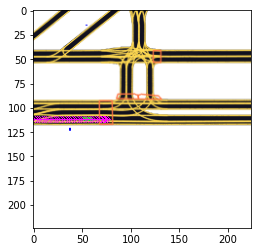

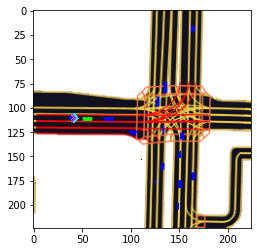

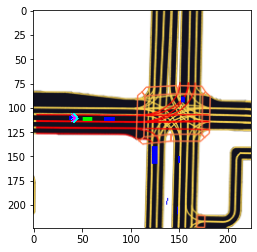

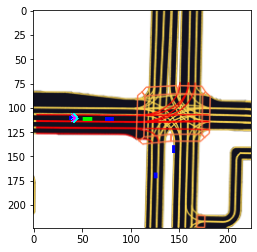

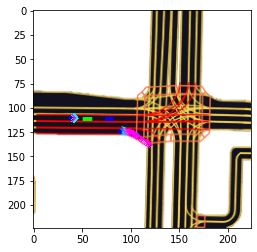

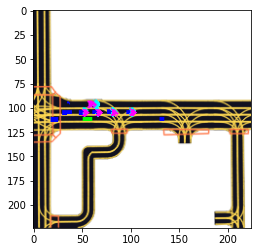

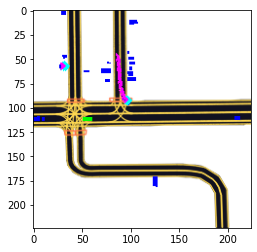

In [ ]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(out_pos + data_agent["centroid"][:2])
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["world_to_image"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["world_to_image"])

    yaws = np.zeros((len(predicted_positions), 1))
    draw_trajectory(im_ego, predicted_positions, yaws, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, yaws, TARGET_POINTS_COLOR)

    plt.imshow(im_ego[::-1])
    plt.show()

Credit: https://github.com/lyft/l5kit/tree/master/examples